### Imports

In [1]:
from dlcliche.image import *
sys.path.append('..') # app
sys.path.append('../..') # root
from easydict import EasyDict
from app_utils_clf import *
from whale_utils import *
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Sampler
import seaborn as sns

### Parameters

In [3]:
args = EasyDict()
args.distance = 'l2'
args.n_train = 1
args.n_test = 1
args.q_train = 2
args.q_test = 1

args.k_train = 80
args.k_test = 41
SZ = 256
RE_SZ = 256

args.n_epochs = 100
args.drop_lr_every = 50
args.lr = 1e-3
args.init_weight = None

data_train = DATA_PATH
data_test  = DATA_PATH

args.checkpoint_monitor = 'categorical_accuracy'
args.checkpoint_period = 20

### Dataset
* n - Reference/Support Images per Class in each episode
* q - Query Images per Class in each episode
* k - Number of Classes in each episode

Grocery Datset
* Total Categories - 7851
    * 1 Reference Image per Category i.e. 7851 Reference Images
    * Only 185 Categories(Food Super Cateogry) have Query Images
        * 948 Query Images for these 185 Categories
* Train/Test Split
    * Categories with only 1 Query Image or 
    * Those with more than 10 Query Images are used only for testing and not included in training
        * 22 Categories with only 1 Query Images
        * 19 Categories with more than 10 Query Images
    * Total 41 Categories are used for testing which have 322 Query Images
    * 144 categories with 626 Images are used for training ProtoNets i.e.Approx 4.34 Query Images per category

In [46]:
refdf = pd.read_csv('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/Grocery_products/reference_metadata.csv')
qdf = pd.read_csv('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/Grocery_products/query_image_metadata.csv')

In [47]:
refdf = refdf[refdf.label.isin(qdf.label.unique())]
refdf.reset_index(drop=True, inplace=True)

refdf['type'] = 'reference'
qdf['type'] = 'query'

refdf.columns = ['image_path', 'class', 'class_id', 'sub_class_label', 'label', 'num_Query_imgs', 'type']

img_df = refdf[['image_path', 'label', 'type']].append(qdf[['image_path', 'label', 'type']], ignore_index=True)

In [48]:
le = LabelEncoder()
img_df['label_id'] = le.fit_transform(img_df.label)
img_df.head(), img_df.tail()

(                       image_path              label       type  label_id
 0   Training/Food/Biscuits/10.jpg   Food_Biscuits_10  reference         0
 1  Training/Food/Biscuits/114.jpg  Food_Biscuits_114  reference         1
 2  Training/Food/Biscuits/115.jpg  Food_Biscuits_115  reference         2
 3  Training/Food/Biscuits/118.jpg  Food_Biscuits_118  reference         3
 4  Training/Food/Biscuits/119.jpg  Food_Biscuits_119  reference         4,
                          image_path        label   type  label_id
 1128  Training/query_images/338.jpg  Food_Tea_83  query       184
 1129  Training/query_images/339.jpg  Food_Tea_83  query       184
 1130  Training/query_images/449.jpg  Food_Tea_83  query       184
 1131  Training/query_images/450.jpg  Food_Tea_83  query       184
 1132  Training/query_images/451.jpg  Food_Tea_83  query       184)

* train(val will be within this itself) and test df. Check how testing is being done now
* Dataloader will give idxs for support followed by query images. Dataset should give imgs accordingly
* Changes dataloader such that all classes are seen in epoch unlike the random choice now
* Change dataset which accepts only df now

In [5]:
test_labels = (list(img_df[img_df['type'] == 'query']['label'].value_counts()[(img_df[img_df['type'] == 'query']['label'].value_counts() == 1).values].index.values)
                    + list(img_df[img_df['type'] == 'query']['label'].value_counts()[(img_df[img_df['type'] == 'query']['label'].value_counts() > 10).values].index.values)
              )

In [6]:
len(test_labels)

41

In [7]:
img_df['split'] = 'train'
img_df.loc[img_df.label.isin(test_labels), 'split'] = 'valid'

In [8]:
img_df.split.value_counts()

train    770
valid    363
Name: split, dtype: int64

In [9]:
trn_df = img_df[img_df.split == 'train']
val_df = img_df[img_df.split == 'valid']

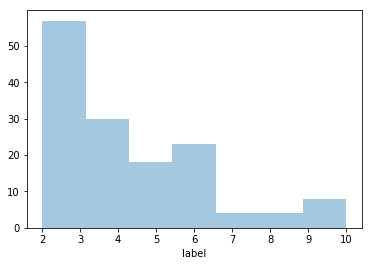

In [10]:
#trn_df[trn_df.type == 'query'].label.value_counts().hist(bins=25)
sns.distplot(trn_df[trn_df.type == 'query'].label.value_counts(), norm_hist=False, kde=False)

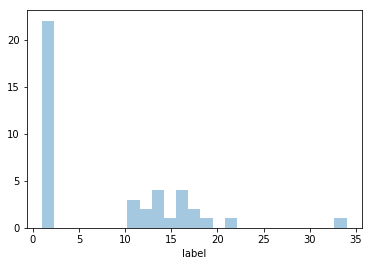

In [11]:
sns.distplot(val_df[val_df.type == 'query'].label.value_counts(), norm_hist=False, kde=False, bins= 25)

In [28]:
args.episodes_per_epoch = roundup((trn_df[trn_df.type == 'reference'].label.nunique())/args.k_train, 1)
args.evaluation_episodes = 100 # setting small value, anyway validation set is almost useless here

In [29]:
def get_aug_custom(re_size=224, to_size=224, train=True):
    augs = [A.Resize(height=re_size, width=re_size)]
    if train:
        augs.extend([
            A.RandomCrop(height=to_size, width=to_size),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=30, p=0.75),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
            A.Blur(p=0.5),
            A.Cutout(max_h_size=to_size//12, max_w_size=to_size//12, p=0.5),
        ])
    else:
        augs.extend([A.CenterCrop(height=to_size, width=to_size)])
    return A.Compose(augs + [A.Normalize()])

In [30]:
def get_aug_plus_custom(re_size=224, to_size=224, augment='train', normalize='imagenet'):
    augs = [A.Resize(height=re_size, width=re_size)]
    if augment == 'train':
        augs.extend([
            A.RandomCrop(height=to_size, width=to_size),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=30, p=0.75),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
            A.Blur(p=0.5),
            A.Cutout(max_h_size=to_size//12, max_w_size=to_size//12, p=0.5),
        ])
    elif augment == 'train_hard':
        augs.extend([
            A.RandomCrop(height=to_size, width=to_size),
            A.IAAAffine(scale=1.3, translate_percent=0.2, translate_px=None,
                                        rotate=40, shear=20),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
            A.IAAPerspective(p=1),
            A.IAAAdditiveGaussianNoise(p=0.2),
            A.Blur(p=0.5),
            A.Cutout(max_h_size=to_size//12, max_w_size=to_size//12, p=0.5),
        ])
    elif augment == 'test':
        augs.extend([
            A.CenterCrop(height=to_size, width=to_size)
        ])
    elif augment == 'tta':
        augs.extend([
            A.IAAAffine(scale=1.05, translate_percent=0.1, translate_px=None, 
                        rotate=20, shear=10),
            A.CenterCrop(height=to_size, width=to_size),
        ])
    else:
        raise Exception(f'aug level not supported: {augment}')
    return A.Compose(augs + [A.Normalize()])

In [31]:
class GrocerImages(Dataset):
    def __init__(self, path, df, re_size=256, to_size=256, train=True):
        self.df = df
        # Index should be same in reference and query df compared to original df
        self.support_df = self.df[self.df.type == 'reference']
        self.query_df = self.df[self.df.type == 'query']
        
        self.classes = sorted(list(set(self.support_df.label_id.values)))

        self.loader = get_img_loader(path, to_gray=False)
        self.transform = get_aug_custom(re_size=re_size, to_size=to_size, train=train)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, item):
        instance = self.loader(self.df.loc[item, 'image_path'])
        instance = self.transform(image=instance)['image']
        instance = self.to_tensor(instance)
        label = self.df.loc[item, 'label_id']
        return instance, label

    def __len__(self):
        return len(self.df)

    def num_classes(self):
        return len(self.cls2imgs)

In [32]:
class GrocerImages_plus(GrocerImages):
    def __init__(self, path, df, re_size=256, to_size=224, part=0, n_part=1,
                 augment='normal', normalize='samplewise'):
        super().__init__(path, df, re_size=re_size, to_size=to_size, train=(augment=='train'))
        self.df = df
        # Index should be same in reference and query df compared to original df

        self.transform = get_aug_plus_custom(re_size=re_size, to_size=to_size, augment=augment, normalize=normalize)
        self.part, self.n_part = part, n_part

    def __getitem__(self, item):
        instance = self.loader(self.df.loc[item, 'image_path'])
#         if self.n_part > 1:
#             instance = partition_np_image(instance, self.part, n_part=self.n_part)
        instance = self.transform(image=instance)['image']
        instance = self.to_tensor(instance)
        label = self.df.loc[item, 'label_id']
        return instance, label

In [33]:
class NShotTaskSampler_custom(Sampler):
    def __init__(self, dataset, episodes_per_epoch, n, k, q):

        super(NShotTaskSampler_custom, self).__init__(dataset)
        self.episodes_per_epoch = episodes_per_epoch
        self.dataset = dataset

        # TODO: Raise errors if initialise badly
        self.k = k
        self.n = n
        self.q = q

    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch = []
            # Get random classes
            support_df = self.dataset.support_df
            query_df = self.dataset.query_df
            episode_classes = np.random.choice(support_df['label_id'].unique(), size=self.k, replace=False)
            
            #df = self.dataset.df[self.dataset.df['class_id'].isin(episode_classes)]

            for k in episode_classes:
                # Select support examples
                support = support_df[support_df['label_id'] == k].sample(self.n)

                for i, s in support.iterrows():
                    batch.append(i)

            for k in episode_classes:
                query = query_df[query_df['label_id'] == k].sample(self.q)
                for i, q in query.iterrows():
                    batch.append(i)

        yield np.stack(batch)

In [34]:
# Dataloader
background = GrocerImages(data_train, trn_df, re_size=RE_SZ, to_size=SZ)
background_taskloader = DataLoader(background, batch_sampler=NShotTaskSampler_custom(background, args.episodes_per_epoch, 
                            args.n_train, args.k_train, args.q_train),num_workers=8)

evaluation = GrocerImages(data_train, val_df, re_size=RE_SZ, to_size=SZ, train=False)
evaluation_taskloader = DataLoader(evaluation, 
            batch_sampler=NShotTaskSampler_custom(evaluation, args.episodes_per_epoch, args.n_test, args.k_test, args.q_test),
    num_workers=8)

#### Loaders Checking

In [20]:
x = next(iter(background_taskloader))

sx = x[0][:args.k_train*args.n_train, ...]
qx = x[0][args.k_train*args.n_train:, ...]

sy = x[1][:args.k_train*args.n_train]
qy = x[1][args.k_train*args.n_train:]

sorted(sy.unique()) == sorted(qy.unique())

True

In [21]:
%matplotlib inline
def show(img):
    img1 = img.numpy()
    img1 = np.transpose(img1, (1,2,0))
    img1 = (img1*std1) + mean1
    #img = img*255.
#     print(img1.shape)
    plt.imshow(img1)#, interpolation = 'nearest')
#     return img1

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

mean1 = mean[None, None, :]
std1 = std[None, None, :]

In [22]:
idx = np.random.randint(0, args.k_train)
imgs = torch.cat((sx[sy == sy.unique()[idx], ...], qx[qy ==sy.unique()[idx], ...]), dim=0)

imgs = torch.FloatTensor(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


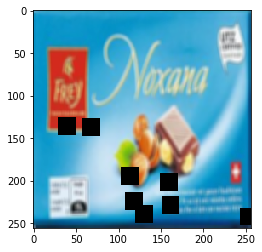

In [23]:
show(imgs[0]); 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


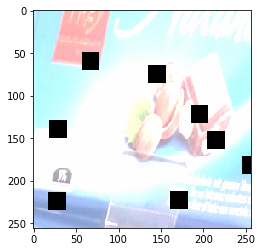

In [24]:
show(imgs[1]);

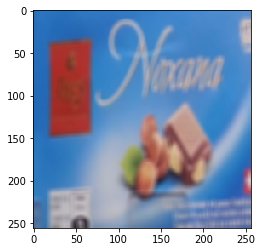

In [25]:
show(imgs[2])

### Modeling
* Pretraining with retail data
* lr_finder
* Freeze Initial layers and train only last layers
* fit_one_cycle
* disriminative learning rates

#### Lr_Finder

In [20]:
from few_shot.proto import proto_net_episode
from few_shot.core import prepare_nshot_task
from torch_lr_finder import LRFinder
from torch import optim

  pip install torch-lr-finder -v --global-option="amp"


In [70]:
from torch_lr_finder.lr_finder import DataLoaderIterWrapper

In [77]:
feature_model = get_resnet34(device=device, weight_file=args.init_weight)

In [78]:
criterion = torch.nn.NLLLoss()

In [79]:
optimizer = optim.Adam(feature_model.parameters(), lr=1e-7)

In [80]:
class lr_finder_proto(LRFinder):
    
    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        super().__init__(model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None)
        self.prepare_batch = prepare_nshot_task(args.n_train, args.k_train, args.q_train)
    
#     def range_test(self, train_loader, val_loader=None, start_lr=None, end_lr=10, num_iter=100, step_mode="exp",
#                     smooth_f=0.05, diverge_th=5, accumulation_steps=1):
#         super().__init__(train_loader, val_loader=None, start_lr=None, end_lr=10, num_iter=100, step_mode="exp",
#                     smooth_f=0.05, diverge_th=5, accumulation_steps=1)
#         self.dl = DataLoaderIterWrapper(train_loader)
    
    def _train_batch(self, iter_wrapper, accumulation_steps):
#         self.model.train()
        total_loss = None  # for late initialization

#         self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            batch = iter_wrapper.get_batch()
            inputs, labels = self.prepare_batch(batch)
#             print(inputs.shape, labels.shape)
            # Forward pass
            loss, y_pred = proto_net_episode(self.model, self.optimizer, self.criterion, inputs, labels, 
                                        args.n_train, args.k_train, args.q_train, distance ='l2' ,train =True)
            
            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
#             loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss
        
        if len(self.history['lr'])>0:
            print(loss, self.history["lr"][-1])

        return total_loss.item()


In [81]:
lr_finder = lr_finder_proto(feature_model, optimizer, criterion, device="cuda", cache_dir = 'logs')

In [82]:
lr_finder.range_test(background_taskloader, end_lr=100, num_iter=150, smooth_f=0.75)

tensor(135.0471, device='cuda:0', grad_fn=<DivBackward0>) 1.1481536214968827e-07
tensor(147.6078, device='cuda:0', grad_fn=<DivBackward0>) 1.318256738556407e-07
tensor(140.4842, device='cuda:0', grad_fn=<DivBackward0>) 1.513561248436208e-07
tensor(132.2170, device='cuda:0', grad_fn=<DivBackward0>) 1.7378008287493754e-07
tensor(124.7322, device='cuda:0', grad_fn=<DivBackward0>) 1.9952623149688795e-07
tensor(119.3566, device='cuda:0', grad_fn=<DivBackward0>) 2.290867652767773e-07
tensor(131.4519, device='cuda:0', grad_fn=<DivBackward0>) 2.630267991895382e-07
tensor(119.7072, device='cuda:0', grad_fn=<DivBackward0>) 3.0199517204020165e-07
tensor(138.7571, device='cuda:0', grad_fn=<DivBackward0>) 3.467368504525316e-07
tensor(145.0004, device='cuda:0', grad_fn=<DivBackward0>) 3.981071705534972e-07
tensor(119.7420, device='cuda:0', grad_fn=<DivBackward0>) 4.5708818961487505e-07
tensor(132.0012, device='cuda:0', grad_fn=<DivBackward0>) 5.248074602497726e-07
tensor(118.5953, device='cuda:0', g

tensor(2.8119, device='cuda:0', grad_fn=<DivBackward0>) 0.22908676527677727
tensor(2.2352, device='cuda:0', grad_fn=<DivBackward0>) 0.2630267991895384
tensor(2.2627, device='cuda:0', grad_fn=<DivBackward0>) 0.30199517204020143
tensor(2.6497, device='cuda:0', grad_fn=<DivBackward0>) 0.3467368504525317
tensor(2.2601, device='cuda:0', grad_fn=<DivBackward0>) 0.3981071705534968
tensor(2.6013, device='cuda:0', grad_fn=<DivBackward0>) 0.45708818961487496
tensor(3.6692, device='cuda:0', grad_fn=<DivBackward0>) 0.5248074602497729
tensor(3.3640, device='cuda:0', grad_fn=<DivBackward0>) 0.6025595860743572
tensor(3.4313, device='cuda:0', grad_fn=<DivBackward0>) 0.6918309709189366
tensor(2.9570, device='cuda:0', grad_fn=<DivBackward0>) 0.7943282347242824
tensor(2.9942, device='cuda:0', grad_fn=<DivBackward0>) 0.9120108393559094
tensor(3.2750, device='cuda:0', grad_fn=<DivBackward0>) 1.0471285480509
tensor(3.0023, device='cuda:0', grad_fn=<DivBackward0>) 1.2022644346174118
tensor(3.8377, device='cu

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/raghava_balusu_walmartlabs_com/anaconda3/envs/proto/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/raghava_balusu_walmartlabs_com/anaconda3/envs/proto/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/raghava_balusu_walmartlabs_com/anaconda3/envs/proto/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/raghava_balusu_walmartlabs_com/anaconda3/envs/proto/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
Traceback (most recent call last):
  File "/home/raghava_balusu_walmartlabs_com/anaconda3/envs/proto/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/raghava_balusu_walmartlabs_com/anaconda3/envs/proto/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._clos

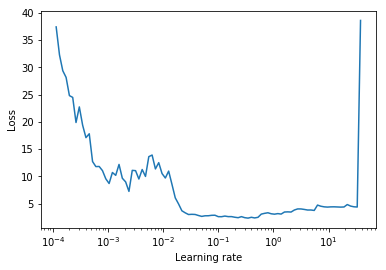

In [83]:
lr_finder.plot(skip_start=50, skip_end=0) # to inspect the loss-learning rate graph

In [50]:
lr_finder.reset() # to reset the model and optimizer to their initial state

#### Training

In [31]:
feature_model = get_resnet34(device=device, weight_file=args.init_weight)

In [18]:
args.param_str = f'Grocer_res34_s{args.n_train}_q{args.q_train}_k{args.k_train}'
args.param_str

'Grocer_res34_s1_q2_k80'

In [23]:
train_proto_net(args,
                model=feature_model,
                device=device,
                path='.',
                n_epochs=args.n_epochs,
                background_taskloader=background_taskloader,
                evaluation_taskloader=evaluation_taskloader,
                drop_lr_every=args.drop_lr_every,
                evaluation_episodes=args.evaluation_episodes,
                episodes_per_epoch=args.episodes_per_epoch,
                lr=args.lr,
               )

Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

Begin training...


Epoch 100: 100%|██████████| 2/2 [00:04<00:00,  2.63s/it, loss=0.581, categorical_accuracy=0.794, val_1-shot_41-way_acc=0.951]

Finished.


In [24]:
f'{args.param_str}_epoch{args.n_epochs}.pth'

'Grocer_res34_s1_q2_k80_epoch100.pth'

In [ ]:
# torch.save(feature_model.state_dict(), f'models/{args.param_str}_epoch{args.n_epochs}.pth')

### Testing
* loader for test query images
* calculate protoypes for all reference images
* Generate embeddings for all query images
* Calculate distance between embeddings and prototypes
* Save top1 and top5 accuracy

In [13]:
from dlcliche.image import *
sys.path.append('..') # app
sys.path.append('../..') # root
from easydict import EasyDict
from app_utils_clf import *
from whale_plus_utils import *
from config import DATA_PATH

In [19]:
exp = f'{args.param_str}_epoch{args.n_epochs}'
# exp = 'res34_untrained_8kcls'
print(exp)
get_model_fn=get_resnet34
weight_file = f'models/{args.param_str}_e{args.n_epochs+1}.pth'
output_path='results'

Grocer_res34_s1_q2_k80_epoch100


In [20]:
SZ=256
device='cuda'
train_csv=DATA_PATH+'/train.csv'
data_train = DATA_PATH
data_test  = DATA_PATH
data_type='normal'
normalize='imagenet'
N_TTA=0
part=0
n_part=1

In [21]:
weight_file = Path(weight_file)
output_path = Path(output_path)
ensure_folder(output_path)

In [22]:
proto_df = pd.read_csv('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/Grocery_products/reference_metadata.csv')

In [23]:
proto_df['type'] = 'reference'

proto_df.columns = ['image_path', 'class', 'class_id', 'sub_class_label', 'label', 'num_Query_imgs', 'type']

In [24]:
le = LabelEncoder()
proto_df['label_id'] = le.fit_transform(proto_df.label)

In [25]:
proto_df.head()

,image_path,class,class_id,sub_class_label,label,num_Query_imgs,type,label_id
0,Training/Beers/Dark/123121.JPG,Beers_Dark,2,123121.0,Beers_Dark_123121,0,reference,0
1,Training/Beers/Dark/14923.JPG,Beers_Dark,2,14923.0,Beers_Dark_14923,0,reference,1
2,Training/Beers/Dark/14925.JPG,Beers_Dark,2,14925.0,Beers_Dark_14925,0,reference,2
3,Training/Beers/Dark/201454.JPG,Beers_Dark,2,201454.0,Beers_Dark_201454,0,reference,3
4,Training/Beers/Dark/201750.JPG,Beers_Dark,2,201750.0,Beers_Dark_201750,0,reference,4


In [26]:
query_df = img_df[img_df.type == 'query'].reset_index(drop=True)
query_df['label_id'] = le.transform(query_df.label.values)

In [35]:
print(f'Test samples: {len(query_df)}.')

# Making dataloaders
def get_dl(df, folder, SZ=SZ, batch_size=256, augment='test', normalize='imagenet'):
    if data_type == 'normal':
        ds = GrocerImages_plus(folder, df, re_size=SZ, to_size=SZ,
                             augment=augment, normalize=normalize, part=part, n_part=n_part)
    else:
        raise ValueError('invalid data type')
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=8)
    return dl

# 1. NORMAL RESULT
# Make prototypes
trn_dl = get_dl(proto_df, data_train)
# model = feature_model
model = get_model_fn(device=device, weight_file=weight_file)
proto_net = ExtModelProtoNetClf(model, trn_dl.dataset.classes, device)
proto_net.make_prototypes(trn_dl)

Test samples: 948.


100%|██████████| 31/31 [00:16<00:00,  3.35it/s]
2020-04-13 06:17:15,092 dlcliche.utils make_prototypes [INFO]: Making new prototypes.


In [36]:
# Calculate distances
test_dl = get_dl(query_df, data_test, batch_size=256)
test_embs, gts = proto_net.get_embeddings(test_dl)
test_dists = proto_net.predict_embeddings(test_embs, softmax=False) #Distance are already negated so dist shub b high now

100%|██████████| 948/948 [00:50<00:00, 19.00it/s]


In [37]:
def stable_softmax(x):
    z = x - x.max(axis=1)[:, None]
    numerator = np.exp(z, )
    denominator = np.sum(numerator, axis=1)[:, None]
    softmax = numerator/denominator
    return softmax

In [38]:
from scipy.special import softmax
test_probs = softmax(test_dists, axis=1)
prototypes = np.array([x.mean() for x in proto_net.prototypes])

In [39]:
(np.argsort(test_dists, axis=1)[:, :5] == np.argsort(test_probs, axis=1)[:, :5]).mean()

1.0

In [40]:
top5labels = np.argsort(-test_dists, axis=1)[:, :5] #- is to sort in descending order

top5preds = [test_dists[i][top5labels[i]] for i in range(test_dists.shape[0])]
top5probs = [test_probs[i][top5labels[i]] for i in range(test_dists.shape[0])]

top5probs = np.array(top5probs)
top5preds = np.array(top5preds)

In [41]:
query_df.columns = ['fpath', 'category', 'type', 'label_id', 'split']

query_df['actual'] = query_df['category']

for i in range(5):
    query_df[f'top_prob'+str(i+1)] = top5probs[:, i]

for i in range(5):
    query_df[f'top_cat'+str(i+1)] = le.inverse_transform(top5labels[:, i])

query_df['pred_cat'] = query_df['top_cat1']

query_df['exp'] = exp

query_df.head()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,top_prob5,top_cat1,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp
0,Training/query_images/380.jpg,Food_Biscuits_10,query,911,train,Food_Biscuits_10,0.175907,0.104308,0.057956,0.047397,0.037634,Food_Biscuits_10,Food_Biscuits_5,Food_Biscuits_26,Food_Biscuits_33,Food_Biscuits_21,Food_Biscuits_10,Grocer_res34_s1_q2_k80_epoch100
1,Training/query_images/381.jpg,Food_Biscuits_10,query,911,train,Food_Biscuits_10,0.142088,0.067990,0.049835,0.042169,0.031590,Food_Biscuits_10,Food_Biscuits_5,Food_Biscuits_26,Food_Biscuits_12,Food_Biscuits_4,Food_Biscuits_10,Grocer_res34_s1_q2_k80_epoch100
2,Training/query_images/514.jpg,Food_Biscuits_10,query,911,train,Food_Biscuits_10,0.196716,0.124897,0.099159,0.037033,0.032318,Food_Biscuits_10,Food_Biscuits_5,Food_Biscuits_33,Food_Biscuits_62,Food_Biscuits_4,Food_Biscuits_10,Grocer_res34_s1_q2_k80_epoch100
3,Training/query_images/516.jpg,Food_Biscuits_10,query,911,train,Food_Biscuits_10,0.233559,0.122402,0.045638,0.045620,0.028162,Food_Biscuits_10,Food_Biscuits_5,Food_Biscuits_33,Food_Biscuits_4,Food_Biscuits_26,Food_Biscuits_10,Grocer_res34_s1_q2_k80_epoch100
4,Training/query_images/541.jpg,Food_Biscuits_10,query,911,train,Food_Biscuits_10,0.398143,0.102663,0.067473,0.060316,0.038930,Food_Biscuits_10,Food_Biscuits_4,Food_Biscuits_5,Food_Biscuits_33,Food_Biscuits_12,Food_Biscuits_10,Grocer_res34_s1_q2_k80_epoch100


In [42]:
query_df['fpath'] = query_df.fpath.map(lambda x : '/Users/r0b03m2/Desktop/Work/Retail_Data/Grocery_products/' + x)

query_df['Flag'] = query_df.apply(lambda x: x['actual'] == x['pred_cat'], axis=1)

query_df['Flag_top5'] = query_df.apply(lambda x: x['actual'] in x[['top_cat1', 'top_cat2', 'top_cat3', 'top_cat4', 'top_cat5']].values, axis=1)

print(query_df.Flag.mean(), query_df.Flag_top5.mean())

print(query_df[query_df.split == 'valid'].Flag.mean(), query_df[query_df.split == 'valid'].Flag_top5.mean())

0.8217299578059072 0.9609704641350211
0.7857142857142857 0.9503105590062112


In [43]:
print(query_df[query_df.split == 'train'].Flag.mean(), query_df[query_df.split == 'train'].Flag_top5.mean())

0.8402555910543131 0.9664536741214057


In [40]:
temp = query_df.groupby(['exp', 'category'])['Flag'].mean().reset_index()
temp.columns = ['exp', 'category', 'accuracy']
query_df = query_df.merge(temp, how='left', on=['exp', 'category'])

temp = query_df.groupby(['exp', 'category'])['Flag_top5'].mean().reset_index()
temp.columns = ['exp', 'category', 'accuracy_Top5']
query_df = query_df.merge(temp, how='left', on=['exp', 'category'])

In [41]:
query_df.head()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,...,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,accuracy,accuracy_Top5
0,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,911,train,Food_Biscuits_10,1.0,2.253973e-18,1.715093e-40,1.357995e-49,...,HouseProducts_Cooking_472,Food_Dairy_Cheese_61,Pets_HygieneAndAccessories_155629,Food_Coffee_13,Food_Biscuits_10,res34_untrained_8kcls,True,True,1.0,1.0
1,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,911,train,Food_Biscuits_10,1.0,3.344813e-26,4.431676e-34,2.373294e-39,...,Food_Biscuits_12,Food_Biscuits_24,HouseProducts_Cooking_472,Food_Dairy_Cheese_61,Food_Biscuits_10,res34_untrained_8kcls,True,True,1.0,1.0
2,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,911,train,Food_Biscuits_10,1.0,1.218954e-41,1.023354e-47,2.526898e-52,...,Food_Dairy_Cheese_61,Food_Jars-Cans_Sauces_158,HouseProducts_Cooking_472,Food_Biscuits_114,Food_Biscuits_10,res34_untrained_8kcls,True,True,1.0,1.0
3,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,911,train,Food_Biscuits_10,1.0,1.745004e-32,2.889143e-45,1.317915e-45,...,Food_Jars-Cans_Sauces_158,Food_Dairy_Cheese_61,Food_Biscuits_24,Food_Biscuits_33,Food_Biscuits_10,res34_untrained_8kcls,True,True,1.0,1.0
4,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,911,train,Food_Biscuits_10,1.0,1.055076e-45,1.579702e-53,3.254151e-56,...,HouseProducts_Cooking_472,Food_Biscuits_114,Food_Biscuits_28,Food_Candy_Chocolate_162,Food_Biscuits_10,res34_untrained_8kcls,True,True,1.0,1.0


In [49]:
result_df = pd.read_csv('results/protonet_results.csv')

In [50]:
result_df.tail()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,...,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,accuracy,accuracy_Top5
10505,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Wines_White_89868,NaN,NaN,NaN,Wines_White_89868,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dummy,NaN,NaN,NaN,NaN
10506,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Wines_White_91891,NaN,NaN,NaN,Wines_White_91891,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dummy,NaN,NaN,NaN,NaN
10507,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Wines_White_95180,NaN,NaN,NaN,Wines_White_95180,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dummy,NaN,NaN,NaN,NaN
10508,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Wines_White_95181,NaN,NaN,NaN,Wines_White_95181,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dummy,NaN,NaN,NaN,NaN
10509,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Wines_White_97255,NaN,NaN,NaN,Wines_White_97255,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dummy,NaN,NaN,NaN,NaN


In [57]:
# result_df.drop(result_df[result_df.exp == 'Grocer_res34_s1_q2_k80_epoch100'].index.values, inplace=True, axis=0)

In [51]:
fin_df = result_df.append(query_df, ignore_index=True)

In [52]:
fin_df.tail()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,...,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,accuracy,accuracy_Top5
11453,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Tea_83,query,3961.0,train,Food_Tea_83,1.0,2.191723e-20,6.045339e-23,1.153960e-23,...,Food_Tea_15,Food_Tea_16,Food_Tea_14,Food_Tea_83,Food_Tea_37,res34_untrained_8kcls,False,True,0.0,1.0
11454,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Tea_83,query,3961.0,train,Food_Tea_83,1.0,1.424305e-28,9.340548e-29,3.831471e-37,...,Food_Tea_15,Food_Tea_83,Food_Tea_16,Food_Tea_14,Food_Tea_37,res34_untrained_8kcls,False,True,0.0,1.0
11455,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Tea_83,query,3961.0,train,Food_Tea_83,1.0,1.398801e-35,4.354014e-37,3.413846e-40,...,Food_Tea_16,Food_Tea_83,Food_Tea_15,Beers_LightAndCider_212823,Food_Tea_37,res34_untrained_8kcls,False,True,0.0,1.0
11456,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Tea_83,query,3961.0,train,Food_Tea_83,1.0,3.591190e-11,2.163036e-20,2.002301e-21,...,Food_Tea_15,Food_Tea_14,Food_Tea_16,Food_Tea_83,Food_Tea_37,res34_untrained_8kcls,False,True,0.0,1.0
11457,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Tea_83,query,3961.0,train,Food_Tea_83,1.0,1.470997e-29,1.052620e-32,9.106199e-35,...,Food_Tea_15,Food_Tea_83,Food_Tea_16,Food_Tea_14,Food_Tea_37,res34_untrained_8kcls,False,True,0.0,1.0


In [53]:
fin_df.head()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,...,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,accuracy,accuracy_Top5
0,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,0.0,train,Food_Biscuits_10,0.008629,0.007199,0.007133,0.007083,...,Food_Coffee_13,Food_Biscuits_114,Food_Cereals_140,Food_Biscuits_12,Food_Biscuits_10,res34_untrained,True,True,1.0,1.0
1,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,0.0,train,Food_Biscuits_10,0.009133,0.008316,0.008079,0.007641,...,Food_Biscuits_12,Food_Biscuits_24,Food_Biscuits_6,Food_Coffee_13,Food_Biscuits_10,res34_untrained,True,True,1.0,1.0
2,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,0.0,train,Food_Biscuits_10,0.009334,0.007663,0.007574,0.007526,...,Food_Biscuits_114,Food_Tea_72,Food_Biscuits_33,Food_Coffee_13,Food_Biscuits_10,res34_untrained,True,True,1.0,1.0
3,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,0.0,train,Food_Biscuits_10,0.009094,0.007711,0.007484,0.007454,...,Food_Biscuits_24,Food_Biscuits_33,Food_Tea_72,Food_Biscuits_28,Food_Biscuits_10,res34_untrained,True,True,1.0,1.0
4,/Users/r0b03m2/Desktop/Work/Retail_Data/Grocer...,Food_Biscuits_10,query,0.0,train,Food_Biscuits_10,0.009180,0.007560,0.007486,0.007305,...,Food_Biscuits_114,Food_Biscuits_28,Food_Biscuits_12,Food_Biscuits_6,Food_Biscuits_10,res34_untrained,True,True,1.0,1.0


In [54]:
fin_df.to_csv('results/protonet_results.csv', index=False)